<a href="https://colab.research.google.com/github/ekolmagorov/StyleTransfer/blob/master/STUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import os
import torch 

from torch.optim import Adam
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from collections import OrderedDict
from torch.utils.tensorboard import SummaryWriter
from google.colab import drive

TODO разобраться с причиной нулевых градиентов - есть подозрение, что копировать тензоры плохая затея поскольку автоматические вызывается .detach()

In [2]:
random.seed(123)
DEVICE  = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

4/1AY0e-g5NK5WsDAYsKgpSmzdSWB2ZEAyHPG5Vwo9U7oLE0-Wrg19cnzv13zc4/1AY0e-g5NK5WsDAYsKgpSmzdSWB2ZEAyHPG5Vwo9U7oLE0-Wrg19cnzv13zc

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
% cd /content/drive/MyDrive/курсовая
#! ls

/content/drive/MyDrive/курсовая


In [5]:
#! unzip style.zip

In [6]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [7]:
resnet = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True)
length = len(list(resnet.children()))
od = OrderedDict()
for index, (name, val) in enumerate(resnet.named_children()):
  if index == length - 2:
    break
  od[name] = val

od

resnet = nn.Sequential(od)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [8]:
vgg = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True).features

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [9]:
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [10]:
len(resnet)

1

In [11]:
example_tensor = torch.randn((1, 3, 256, 256))
out = vgg(example_tensor)
out.shape

torch.Size([1, 512, 8, 8])

In [12]:
hasattr(vgg, '6')
getattr(vgg, '6')

ReLU(inplace=True)

In [13]:
class EncoderBlock(nn.Module):

    '''
    Encoder part in Unet-style neural network model
    '''

    def __get_activation(self, name):
        def __hook(module, input, output):
            self.output[name] = output

        return __hook


    def __init__(self, encoder_model, output_layers=None):
      super(EncoderBlock, self).__init__()

      self.model = encoder_model

      self.output_layers = output_layers
      self.output = {}

      if output_layers is not None:
        
        for idx, layer_name in enumerate(output_layers):

          if not hasattr(self.model, layer_name):
            raise KeyError("such {} in your encoder model doesn't exist".
                           format(layer_name))

          getattr(self.model, layer_name).register_forward_hook(
              self.__get_activation(layer_name)
              )


    def forward(self, x):

      self.output.clear()
      out = self.model(x)
      self.output['out'] = out
      return out, self.output.copy()

In [14]:
LAYERS_NAME = ['1', '6', '11', '18', '25']
encoder = EncoderBlock(vgg, LAYERS_NAME)

In [15]:
example_tensor = torch.randn((1, 3, 256, 256))
out, d_out = encoder(example_tensor)

In [16]:
#print(out, )

In [17]:
#TODO add weights to signal after adain transformation

class AdainBlock(nn.Module):

    def __init__(self, layers_names):
        super(AdainBlock, self).__init__()
        self.layers_names = layers_names
        self.outputs = {}

    def transform(self, content, style):
        content_sigma = torch.std(content, dim=(2, 3), keepdims=True)
        style_sigma = torch.std(style, dim=(2, 3), keepdims=True)

        content_mu = torch.mean(content, dim=(2, 3), keepdims=True)
        style_mu = torch.mean(style, dim=(2, 3), keepdims=True)

        
        out = style_sigma * ((content - content_mu)/ (content_sigma + 1e-5)) + style_mu

        return  out

    def forward(self, content_features, style_features):

        self.outputs.clear()

        for layer_name in self.layers_names:

            self.outputs[layer_name] = self.transform(
                                              content_features[layer_name],
                                              style_features[layer_name])
            
        return self.outputs.copy()


In [18]:
example_tensor_c = torch.randn((1, 3, 256, 256))
example_tensor_s = torch.randn((1, 3, 256, 256))

adain = AdainBlock(LAYERS_NAME + ['out'])

out_c, d_out_c = encoder(example_tensor_c)
out_s, d_out_s = encoder(example_tensor_s)

outputs = adain(d_out_c, d_out_s)
for name, value in outputs.items():
    print("name: {}, shape: {}".format(name, value.shape))

name: 1, shape: torch.Size([1, 64, 256, 256])
name: 6, shape: torch.Size([1, 128, 128, 128])
name: 11, shape: torch.Size([1, 256, 64, 64])
name: 18, shape: torch.Size([1, 512, 32, 32])
name: 25, shape: torch.Size([1, 512, 16, 16])
name: out, shape: torch.Size([1, 512, 8, 8])


In [19]:
#print(outputs)

In [20]:
'''
out_height, out_width = out.shape[-2:]
skip_height, skip_width = skip_feature.shape[-2:]

out_height_pad = out_height - max(out_height, skip_height)
out_width_pad = out_width - max(out_width, skip_width)

skip_height_pad = skip_height - max(out_height, skip_height)
skip_width_pad = skip_width - max(out_width, skip_width)

out = nn.ZeroPad2d((out_height_pad, 0, out_width_pad))(out)
skip_feature = nn.ZeroPad2d((skip_height_pad, 0, skip_width_pad))(skip_feature)
d'''

'\nout_height, out_width = out.shape[-2:]\nskip_height, skip_width = skip_feature.shape[-2:]\n\nout_height_pad = out_height - max(out_height, skip_height)\nout_width_pad = out_width - max(out_width, skip_width)\n\nskip_height_pad = skip_height - max(out_height, skip_height)\nskip_width_pad = skip_width - max(out_width, skip_width)\n\nout = nn.ZeroPad2d((out_height_pad, 0, out_width_pad))(out)\nskip_feature = nn.ZeroPad2d((skip_height_pad, 0, skip_width_pad))(skip_feature)\nd'

In [21]:
def crop_tensors(first, second):
    first_height, first_width = first.shape[-2:]
    second_height, second_width = second.shape[-2:]

    min_height = min(first_height, second_height)
    min_width = min(first_width, second_width)

    first = first[:, :, :min_height, :min_width]
    second = second[:, :, :min_height, :min_width]

    return first, second


class DecoderBlock(nn.Module):
  
    def createDecoderBlock(self, in_channels, out_channels, kernel_size=3,
                           stride=1, scale_factor=2):
        decoder_block = nn.Sequential(OrderedDict([
            ('upsample', nn.Upsample(scale_factor=scale_factor)),
            ('conv', nn.Conv2d(in_channels,
                                out_channels,
                                kernel_size=kernel_size,
                                stride=stride,
                               padding=1))]))
        
        return decoder_block

    def __init__(self, channels_sizes):
      

        super(DecoderBlock, self).__init__()
        self.decoder_channels = channels_sizes
        self.weights = torch.ones(len(channels_sizes), 1), requires_grad=True) 
        self.decoder_layers = nn.ModuleList(
            [self.createDecoderBlock(c_size_in, c_size_out) 
            for (c_size_in, c_size_out) in channels_sizes]
            )

        self.last_decoder_layer = self.createDecoderBlock(channels_sizes[-1][-1], 3, scale_factor=1)

        self.last_layer_act = nn.ReLU()#nn.Sigmoid()

    def forward(self, out, skip_features):

        skip_features = skip_features[::-1]


        for idx, skip_feature in enumerate(skip_features):

          
            out = nn.ReLU()(self.decoder_layers[idx](out))
            out, skip_feature = crop_tensors(out, skip_feature)

            out = out + self.weights[idx] * skip_feature

        out = self.last_decoder_layer(out)

        return out

In [22]:
CHANNELS_SIZES = [(512, 512),
                  (512, 512),
                  (512, 256),
                  (256, 128),
                  (128, 64)]

decoder = DecoderBlock(CHANNELS_SIZES)

channels_orders = {
    0: '1',
    1: '6',
    2: '11',
    3: '18',
    4: '25'}

skip_features = [outputs[channels_orders[i]]
                 for i in range(len(channels_orders))]

x = decoder(outputs['out'], skip_features)
x.shape

torch.Size([1, 3, 256, 256])

In [23]:
class STUNet(nn.Module):

    def __init__(self, encoder_block, adain_block, decoder_block,
                 skip_layers, features_sizes):

          super(STUNet, self).__init__()
          self.encoder_model = EncoderBlock(encoder_block, skip_layers)
          self.adain_model = AdainBlock(skip_layers)
          self.decoder_model = DecoderBlock(features_sizes)

    def forward(self, content_images, style_images):

        enc_out_c, enc_d_out_c = self.encoder_model(content_images)
        enc_out_s, enc_d_out_s = self.encoder_model(style_images)
        #print(enc_d_out_c, enc_d_out_s)
        adain_out  = adain.transform(enc_out_c, enc_out_s) 
        adain_outs = adain(enc_d_out_c, enc_d_out_s)

        skip_features = [adain_outs[channels_orders[i]]
                 for i in range(len(channels_orders))]

        out = self.decoder_model(adain_out, skip_features)

        return out

In [24]:
#resnet = nn.Sequential(od)
adain = AdainBlock(LAYERS_NAME)
decoder = DecoderBlock(CHANNELS_SIZES)


main_model = STUNet(vgg, adain, decoder, LAYERS_NAME, CHANNELS_SIZES).to(DEVICE)

In [25]:
example_tensor_c = torch.randn((1, 3, 512, 512)).to(DEVICE)
example_tensor_s = torch.randn((1, 3, 512, 512)).to(DEVICE)

x = main_model(example_tensor_c, example_tensor_s)

In [26]:
x.shape

torch.Size([1, 3, 512, 512])

In [27]:
from skimage.io import imread

class STDataSet(Dataset):

    def __init__(self, content_filenames, style_filenames, get_random=True, **kwargs):
        self.style_filenames = style_filenames
        self.content_filenames = content_filenames

        self.get_random = get_random
        self.kwargs = kwargs
      
        if not self.get_random:
            l_style = len(self.style_filenames)
            l_content = len(self.content_filenames)

            styles_filenames = [
                                     self.style_filenames[i]
                                     for i in range(len(self.style_filenames))
                                     for j in range(len(self.content_filenames))
                                    ]

            content_filenames = [
                                      self.content_filename[j]
                                      for i in range(self.style_filenames)
                                      for j in range(self.content_filenames)
                                      ]

            self.train_set = zip(content_filenames, styles_filenames)
        

    def __len__(self):
      return len(self.style_filenames) * len(self.content_filenames)
    
    def __getitem__(self, idx):
      if torch.is_tensor(idx):
            idx = idx.tolist()
    
      if self.get_random:
          content_filename = self.content_filenames[
                                random.randint(0, len(self.content_filenames)-1)
                                ]

          style_filename = self.style_filenames[
                                random.randint(0, len(self.style_filenames)-1)
                                ]
         
      else:
          content_filename, style_filename = self.train_set[idx]

      content, style = Image.open(content_filename), Image.open(style_filename)

      if 'content_transform' in self.kwargs:
          content = self.kwargs['content_transform'](content)
      
      if 'style_transform' in self.kwargs:
          style = self.kwargs['style_transform'](style)
      #print(style.shape)
      return (content, style)

In [28]:
contents_dir, styles_dir = 'contents', 'styles'
content_filenames = [os.path.join(contents_dir, filename)
                    for filename in os.listdir(contents_dir)]

style_filenames = [os.path.join(styles_dir, filename) 
                  for filename in  os.listdir(styles_dir)]

In [29]:
dataset = STDataSet(content_filenames, style_filenames,
                    style_transform=transforms.ToTensor(),
                    content_transform=transforms.ToTensor())

content, style = dataset[1]

#fig, axes = plt.subplots(1,2, figsize=(15, 15))
#axes[0].imshow(content)
#axes[1].imshow(style)

In [43]:
class TransformerLoss(EncoderBlock):

    def __init__(self, encoder_model, output_layers=None, weights=None):
        if weights is not None:
            assert len(output_layers) == len(weights)

        self.weights = weights

        super(TransformerLoss, self).__init__(encoder_model, output_layers)
        for param in self.model.parameters():
            param.requires_grad = False

    @staticmethod
    def compute_style_loss(first_tensor, second_tensor):
        first_tensor_mean = torch.mean(first_tensor, dim=(-1, -2))
        second_tensor_mean = torch.mean(second_tensor, dim=(-1, -2))

        mu_diff = torch.mean(torch.sqrt(
            torch.sum((first_tensor_mean - second_tensor_mean) ** 2, dim=-1)
            ))

        first_tensor_std = torch.std(first_tensor, dim=(-1, -2))
        second_tensor_std = torch.std(second_tensor, dim=(-1, -2))

        std_diff = torch.mean(torch.sqrt(
            torch.sum((first_tensor_std - second_tensor_std) ** 2, dim=-1)
            ))


        total_diff = mu_diff + std_diff
 
        return total_diff

    @staticmethod
    def compute_content_loss(first_tensor, second_tensor):

        tensor_diff = torch.mean(torch.sqrt(
              torch.sum((first_tensor - second_tensor) ** 2, dim=(1,2,3))
              ))
        #tensor_diff = torch.sqrt(nn.MSELoss(first_tensor, second_tensor, reduction='sum')

        return tensor_diff


    def __compute_loss(self, enc_first, enc_second, func):
        assert enc_first.keys() == enc_second.keys()


        loss = 0
        for key in self.output_layers:
            
            first_tensor, second_tensor = enc_first[key], enc_second[key]

            l = func(first_tensor, second_tensor)

            loss +=  l * self.weights[key] if self.weights[key] is not None else l
        return loss
            
            
            

        return mu_diff + std_diff

    def __call__(self, content, style, out):

        content, out = crop_tensors(content, out)
        enc_content, enc_content_d = EncoderBlock.__call__(self, content)
        #print(enc_content_d)
        enc_style, enc_style_d = EncoderBlock.__call__(self, style)
        #print(enc_style_d)
        enc_out, enc_out_d = EncoderBlock.__call__(self, out)
        
        c_loss = self.__compute_loss(enc_out_d,
                                     enc_content_d,
                                     self.compute_content_loss)
        
        s_loss = self.__compute_loss(enc_out_d,
                                     enc_style_d,
                                     self.compute_style_loss)

        return c_loss, s_loss

In [44]:
vgg19 = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [46]:
layers = ['6', '11']
weights = {'6':1,
           '11':2}


loss_model = TransformerLoss(vgg19.features, layers, weights).eval()

random.seed(None)
content_example = torch.zeros(2, 3, 512, 512)
style_example = torch.ones(2, 3, 256, 256)
out_example = (torch.ones(2, 3, 512, 512) / 2)

c_loss, s_loss = loss_model(content_example,
                                       style_example,
                                       out_example)

print("C_loss : {}, s_loss: {}".format(c_loss.item(), s_loss.item()))

C_loss : 750.4810791015625, s_loss: 10.269607543945312


In [33]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import Line2D

def plot_grad_flow_v2(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    #plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [34]:
import time
count_num_params = lambda model: sum(p.numel() for p in model.parameters()
                                    if p.requires_grad)



def get_cuda_mem_info():
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0) 
    a = torch.cuda.memory_allocated(0)

    return t, r, a

def train(model, optimizer, dataset, loss_fn, num_steps, batch_size=1, lr=1e-3, alpha=1, out_frequency=None):

    print("Start:{},{}, {}".format(*get_cuda_mem_info()))
    model.train()
    model = model.to(DEVICE)
    print("After model:{},{}, {}".format(*get_cuda_mem_info()))
    loss_fn = loss_fn.eval().to(DEVICE)
    print("After loss:{},{}, {}".format(*get_cuda_mem_info()))
    num_params = count_num_params(model)
    print("Train model with: {} parameters".format(num_params))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    optimizer = optimizer(model.parameters(), lr=lr)
    writer = SummaryWriter()
    #writer.add_graph(model)

    dataloader_size = len(dataloader)
    num_iters, window_loss = 0, 0

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    c_loss, s_loss = 0, 0
    while num_iters < num_steps:
      for idx, (contents, styles) in enumerate(dataloader):
          #print(num_iters)
          if num_iters > num_steps:
              break
          n_channels, style_height, style_width = styles.shape[-3:]
          if style_height > 800 or style_width > 800 or n_channels < 3:
            continue


          contents, styles = contents.to(DEVICE), styles.to(DEVICE)

          optimizer.zero_grad()

          out_img = model(contents, styles)

          c_loss, s_loss = loss_fn(normalize(contents),
                                  normalize(styles),
                                  normalize(out_img))


          loss =  s_loss + alpha * c_loss

          loss.backward()

          
          optimizer.step()
          num_iters += 1
          c_loss += c_loss.item()
          s_loss += s_loss.item()
          window_loss += loss.item()


          if (out_frequency) and not (num_iters % out_frequency):
              for n, p in model.named_parameters():
                print(n, p.grad.max(), p.grad.min())
              plot_grad_flow_v2(model.named_parameters())
              plt.show()
              window_loss /= out_frequency
              c_loss /= out_frequency
              s_loss / out_frequency

              print("Iter: {} | Train loss on last  {} : total - {}, content-{}, style-{}".format(num_iters,
                                                                    out_frequency,
                                                                    window_loss,
                                                                    c_loss, s_loss
                                                                    ))
              window_loss, c_loss, s_loss = 0, 0, 0

    return model, writer

Start:11996954624,1862270976, 1678587392
After model:11996954624,1862270976, 1678587392
After loss:11996954624,1862270976, 1738626560
Train model with: 20984771 parameters
encoder_model.model.0.weight tensor(2.5685, device='cuda:0') tensor(-2.5413, device='cuda:0')
encoder_model.model.0.bias tensor(3.2291, device='cuda:0') tensor(-3.0001, device='cuda:0')
encoder_model.model.2.weight tensor(0.6250, device='cuda:0') tensor(-0.7541, device='cuda:0')
encoder_model.model.2.bias tensor(0.6668, device='cuda:0') tensor(-1.0777, device='cuda:0')
encoder_model.model.5.weight tensor(1.3011, device='cuda:0') tensor(-1.1083, device='cuda:0')
encoder_model.model.5.bias tensor(0.5302, device='cuda:0') tensor(-0.4216, device='cuda:0')
encoder_model.model.7.weight tensor(0.1704, device='cuda:0') tensor(-0.2886, device='cuda:0')
encoder_model.model.7.bias tensor(0.1464, device='cuda:0') tensor(-0.2213, device='cuda:0')
encoder_model.model.10.weight tensor(0.3213, device='cuda:0') tensor(-0.2684, device

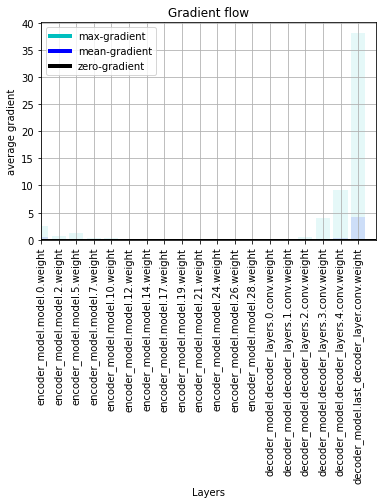

Iter: 10 | Train loss on last  10 : total - 288.1658874511719, content-4912.9931640625, style-94.19100189208984
encoder_model.model.0.weight tensor(4.1009, device='cuda:0') tensor(-2.9677, device='cuda:0')
encoder_model.model.0.bias tensor(3.7942, device='cuda:0') tensor(-4.4433, device='cuda:0')
encoder_model.model.2.weight tensor(1.2647, device='cuda:0') tensor(-0.9911, device='cuda:0')
encoder_model.model.2.bias tensor(2.0289, device='cuda:0') tensor(-1.4503, device='cuda:0')
encoder_model.model.5.weight tensor(1.7876, device='cuda:0') tensor(-1.2847, device='cuda:0')
encoder_model.model.5.bias tensor(0.8670, device='cuda:0') tensor(-0.7408, device='cuda:0')
encoder_model.model.7.weight tensor(0.3549, device='cuda:0') tensor(-0.2684, device='cuda:0')
encoder_model.model.7.bias tensor(0.3040, device='cuda:0') tensor(-0.2298, device='cuda:0')
encoder_model.model.10.weight tensor(0.3697, device='cuda:0') tensor(-0.3229, device='cuda:0')
encoder_model.model.10.bias tensor(0.1727, device

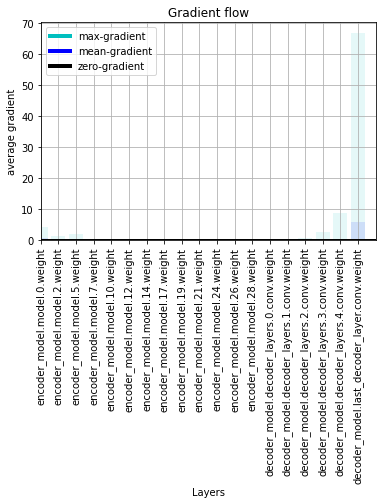

Iter: 20 | Train loss on last  10 : total - 274.0212707519531, content-4884.59765625, style-81.72697448730469
encoder_model.model.0.weight tensor(3.0486, device='cuda:0') tensor(-2.6687, device='cuda:0')
encoder_model.model.0.bias tensor(2.2233, device='cuda:0') tensor(-4.0010, device='cuda:0')
encoder_model.model.2.weight tensor(0.9780, device='cuda:0') tensor(-0.8639, device='cuda:0')
encoder_model.model.2.bias tensor(0.8654, device='cuda:0') tensor(-0.7849, device='cuda:0')
encoder_model.model.5.weight tensor(2.2075, device='cuda:0') tensor(-1.8069, device='cuda:0')
encoder_model.model.5.bias tensor(0.6338, device='cuda:0') tensor(-0.6806, device='cuda:0')
encoder_model.model.7.weight tensor(0.4149, device='cuda:0') tensor(-0.3870, device='cuda:0')
encoder_model.model.7.bias tensor(0.2655, device='cuda:0') tensor(-0.1962, device='cuda:0')
encoder_model.model.10.weight tensor(0.3902, device='cuda:0') tensor(-0.5025, device='cuda:0')
encoder_model.model.10.bias tensor(0.1346, device='

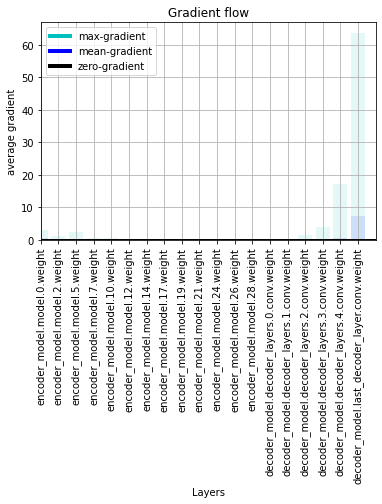

Iter: 30 | Train loss on last  10 : total - 257.7259811401367, content-4355.61376953125, style-147.54559326171875
encoder_model.model.0.weight tensor(2.7697, device='cuda:0') tensor(-2.5478, device='cuda:0')
encoder_model.model.0.bias tensor(2.7912, device='cuda:0') tensor(-4.1715, device='cuda:0')
encoder_model.model.2.weight tensor(0.7647, device='cuda:0') tensor(-0.6950, device='cuda:0')
encoder_model.model.2.bias tensor(1.1952, device='cuda:0') tensor(-0.9041, device='cuda:0')
encoder_model.model.5.weight tensor(2.2583, device='cuda:0') tensor(-1.3671, device='cuda:0')
encoder_model.model.5.bias tensor(0.6334, device='cuda:0') tensor(-0.6147, device='cuda:0')
encoder_model.model.7.weight tensor(0.7860, device='cuda:0') tensor(-0.3669, device='cuda:0')
encoder_model.model.7.bias tensor(0.3139, device='cuda:0') tensor(-0.2189, device='cuda:0')
encoder_model.model.10.weight tensor(0.4198, device='cuda:0') tensor(-0.2964, device='cuda:0')
encoder_model.model.10.bias tensor(0.1422, devi

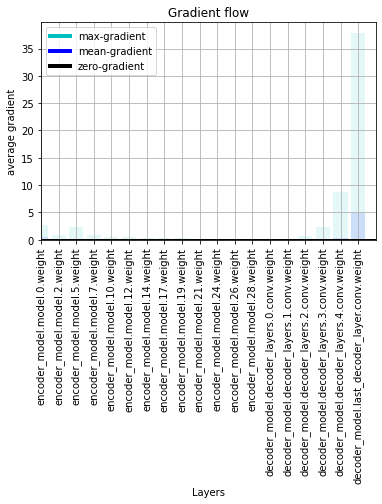

Iter: 40 | Train loss on last  10 : total - 238.74004516601562, content-4132.236328125, style-229.59779357910156
encoder_model.model.0.weight tensor(3.2815, device='cuda:0') tensor(-2.1696, device='cuda:0')
encoder_model.model.0.bias tensor(3.8210, device='cuda:0') tensor(-3.4023, device='cuda:0')
encoder_model.model.2.weight tensor(1.5249, device='cuda:0') tensor(-1.3291, device='cuda:0')
encoder_model.model.2.bias tensor(1.6886, device='cuda:0') tensor(-2.1600, device='cuda:0')
encoder_model.model.5.weight tensor(1.6343, device='cuda:0') tensor(-1.1732, device='cuda:0')
encoder_model.model.5.bias tensor(1.0722, device='cuda:0') tensor(-0.8163, device='cuda:0')
encoder_model.model.7.weight tensor(0.6650, device='cuda:0') tensor(-0.5212, device='cuda:0')
encoder_model.model.7.bias tensor(0.4877, device='cuda:0') tensor(-0.3581, device='cuda:0')
encoder_model.model.10.weight tensor(0.4064, device='cuda:0') tensor(-0.5137, device='cuda:0')
encoder_model.model.10.bias tensor(0.1665, devic

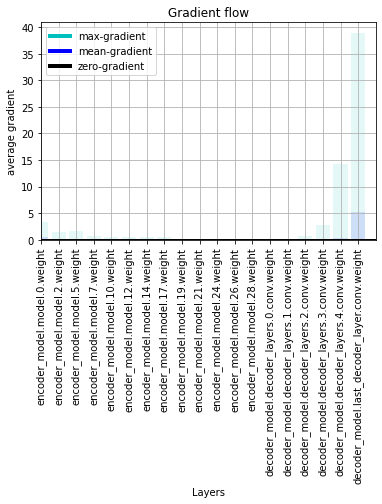

Iter: 50 | Train loss on last  10 : total - 233.30904388427734, content-1790.9608154296875, style-100.15605163574219
encoder_model.model.0.weight tensor(3.3209, device='cuda:0') tensor(-3.8638, device='cuda:0')
encoder_model.model.0.bias tensor(5.6137, device='cuda:0') tensor(-6.0711, device='cuda:0')
encoder_model.model.2.weight tensor(1.4942, device='cuda:0') tensor(-1.1939, device='cuda:0')
encoder_model.model.2.bias tensor(1.9997, device='cuda:0') tensor(-2.0181, device='cuda:0')
encoder_model.model.5.weight tensor(1.5810, device='cuda:0') tensor(-1.8223, device='cuda:0')
encoder_model.model.5.bias tensor(0.9764, device='cuda:0') tensor(-1.3538, device='cuda:0')
encoder_model.model.7.weight tensor(0.7528, device='cuda:0') tensor(-1.0124, device='cuda:0')
encoder_model.model.7.bias tensor(0.5726, device='cuda:0') tensor(-0.7668, device='cuda:0')
encoder_model.model.10.weight tensor(0.4820, device='cuda:0') tensor(-0.4338, device='cuda:0')
encoder_model.model.10.bias tensor(0.2427, d

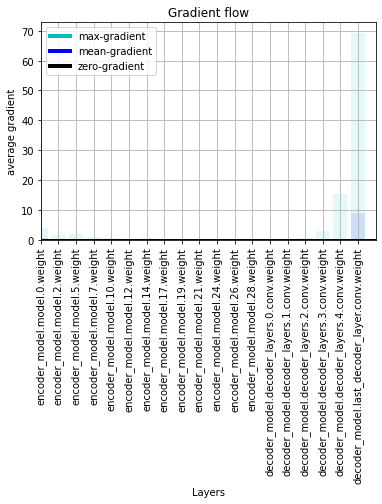

Iter: 60 | Train loss on last  10 : total - 220.1302574157715, content-1668.3934326171875, style-77.04313659667969
encoder_model.model.0.weight tensor(5.2682, device='cuda:0') tensor(-3.0619, device='cuda:0')
encoder_model.model.0.bias tensor(6.8775, device='cuda:0') tensor(-4.3219, device='cuda:0')
encoder_model.model.2.weight tensor(2.0704, device='cuda:0') tensor(-1.2923, device='cuda:0')
encoder_model.model.2.bias tensor(1.8361, device='cuda:0') tensor(-1.8871, device='cuda:0')
encoder_model.model.5.weight tensor(2.1630, device='cuda:0') tensor(-2.0115, device='cuda:0')
encoder_model.model.5.bias tensor(0.9600, device='cuda:0') tensor(-0.6686, device='cuda:0')
encoder_model.model.7.weight tensor(0.8058, device='cuda:0') tensor(-0.6031, device='cuda:0')
encoder_model.model.7.bias tensor(0.4670, device='cuda:0') tensor(-0.4336, device='cuda:0')
encoder_model.model.10.weight tensor(0.9868, device='cuda:0') tensor(-0.7795, device='cuda:0')
encoder_model.model.10.bias tensor(0.3009, dev

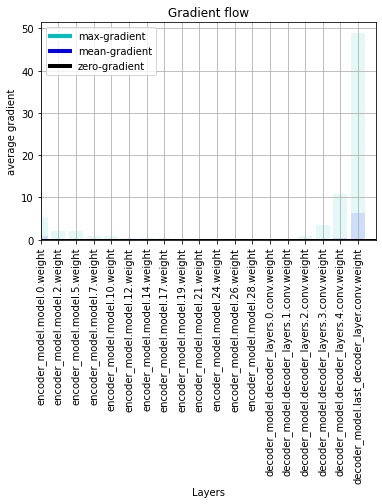

Iter: 70 | Train loss on last  10 : total - 233.9957534790039, content-1795.95703125, style-219.41659545898438
encoder_model.model.0.weight tensor(4.0784, device='cuda:0') tensor(-3.2114, device='cuda:0')
encoder_model.model.0.bias tensor(5.1730, device='cuda:0') tensor(-4.7674, device='cuda:0')
encoder_model.model.2.weight tensor(1.3471, device='cuda:0') tensor(-1.6725, device='cuda:0')
encoder_model.model.2.bias tensor(2.1520, device='cuda:0') tensor(-2.4222, device='cuda:0')
encoder_model.model.5.weight tensor(1.0835, device='cuda:0') tensor(-1.9500, device='cuda:0')
encoder_model.model.5.bias tensor(0.7324, device='cuda:0') tensor(-1.4248, device='cuda:0')
encoder_model.model.7.weight tensor(0.9191, device='cuda:0') tensor(-0.6667, device='cuda:0')
encoder_model.model.7.bias tensor(0.6588, device='cuda:0') tensor(-0.5448, device='cuda:0')
encoder_model.model.10.weight tensor(0.4607, device='cuda:0') tensor(-0.4758, device='cuda:0')
encoder_model.model.10.bias tensor(0.2561, device=

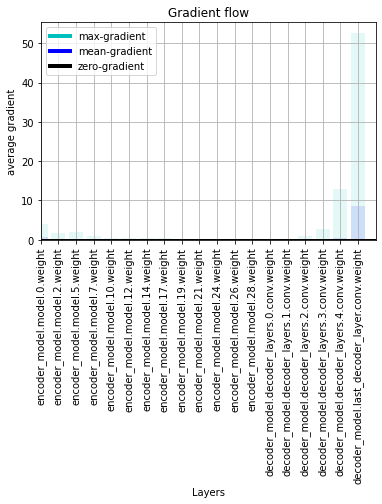

Iter: 80 | Train loss on last  10 : total - 212.53179321289062, content-2627.679443359375, style-60.0647087097168
encoder_model.model.0.weight tensor(1.7529, device='cuda:0') tensor(-2.9141, device='cuda:0')
encoder_model.model.0.bias tensor(2.1305, device='cuda:0') tensor(-3.4315, device='cuda:0')
encoder_model.model.2.weight tensor(0.9694, device='cuda:0') tensor(-1.0474, device='cuda:0')
encoder_model.model.2.bias tensor(0.9109, device='cuda:0') tensor(-1.4335, device='cuda:0')
encoder_model.model.5.weight tensor(0.8671, device='cuda:0') tensor(-0.9326, device='cuda:0')
encoder_model.model.5.bias tensor(0.3578, device='cuda:0') tensor(-0.6339, device='cuda:0')
encoder_model.model.7.weight tensor(0.3970, device='cuda:0') tensor(-0.5465, device='cuda:0')
encoder_model.model.7.bias tensor(0.1781, device='cuda:0') tensor(-0.3313, device='cuda:0')
encoder_model.model.10.weight tensor(0.3416, device='cuda:0') tensor(-0.3724, device='cuda:0')
encoder_model.model.10.bias tensor(0.1379, devi

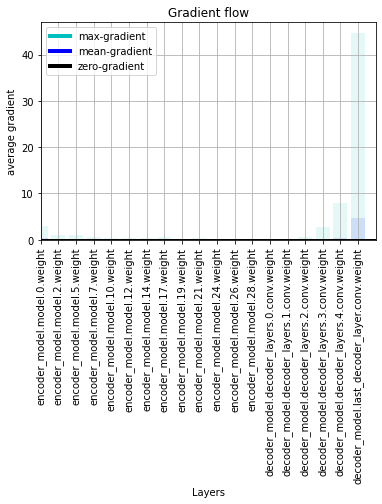

Iter: 90 | Train loss on last  10 : total - 205.82243423461915, content-2281.722412109375, style-99.23027038574219
encoder_model.model.0.weight tensor(4.7326, device='cuda:0') tensor(-4.3790, device='cuda:0')
encoder_model.model.0.bias tensor(7.3985, device='cuda:0') tensor(-7.0421, device='cuda:0')
encoder_model.model.2.weight tensor(1.6856, device='cuda:0') tensor(-1.5038, device='cuda:0')
encoder_model.model.2.bias tensor(2.1690, device='cuda:0') tensor(-1.6816, device='cuda:0')
encoder_model.model.5.weight tensor(1.8708, device='cuda:0') tensor(-1.5711, device='cuda:0')
encoder_model.model.5.bias tensor(1.0863, device='cuda:0') tensor(-1.1247, device='cuda:0')
encoder_model.model.7.weight tensor(0.8447, device='cuda:0') tensor(-0.8327, device='cuda:0')
encoder_model.model.7.bias tensor(0.5496, device='cuda:0') tensor(-0.6985, device='cuda:0')
encoder_model.model.10.weight tensor(0.6698, device='cuda:0') tensor(-0.5156, device='cuda:0')
encoder_model.model.10.bias tensor(0.3397, dev

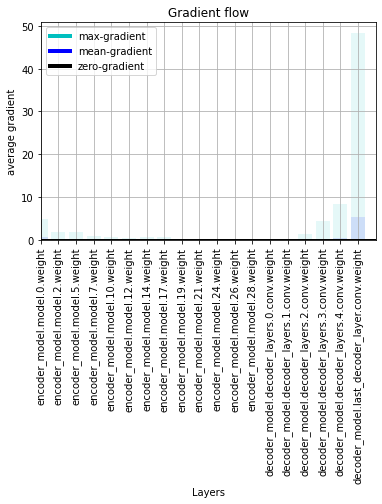

Iter: 100 | Train loss on last  10 : total - 184.29212799072266, content-2287.846923828125, style-105.272705078125


In [35]:
main_model, writer = train(main_model,
                   Adam,
                   dataset,
                   loss_model,
                   100,
                   batch_size=10,
                   lr=1e-4,
                   out_frequency=10,
                   alpha=1e-2)

In [38]:
main_model, writer = main_model

In [39]:
torch.cuda.empty_cache()


contents, styles = dataset[13]
contents_t, styles_t = torch.unsqueeze(contents, 0).to(DEVICE), torch.unsqueeze(styles, 0).to(DEVICE)

out_img = main_model.eval()(contents_t, styles_t)[0]
print(out_img.shape, contents.shape)
pil_img = transforms.ToPILImage()(out_img.detach())



torch.Size([3, 800, 608]) torch.Size([3, 830, 622])


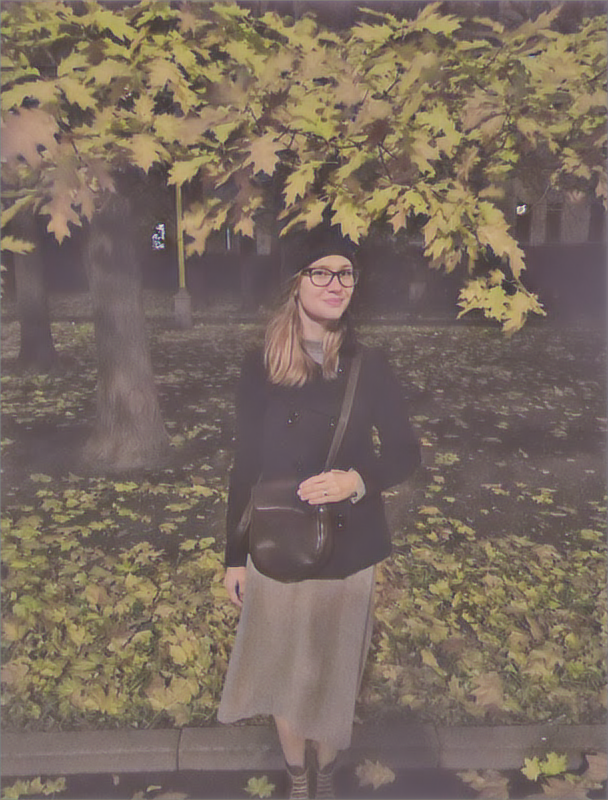

In [40]:
from IPython.display import display # to display images
display(pil_img)

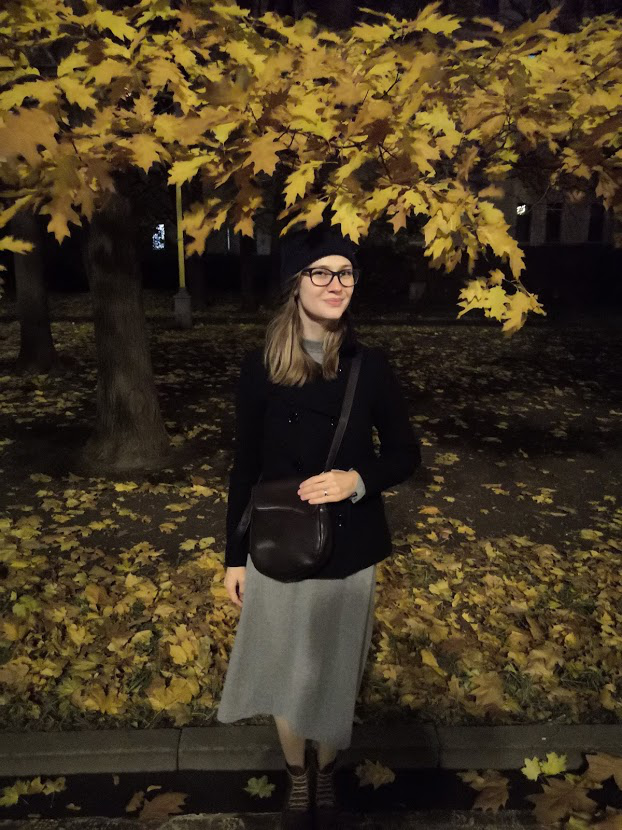

In [41]:
display(transforms.ToPILImage()(contents))

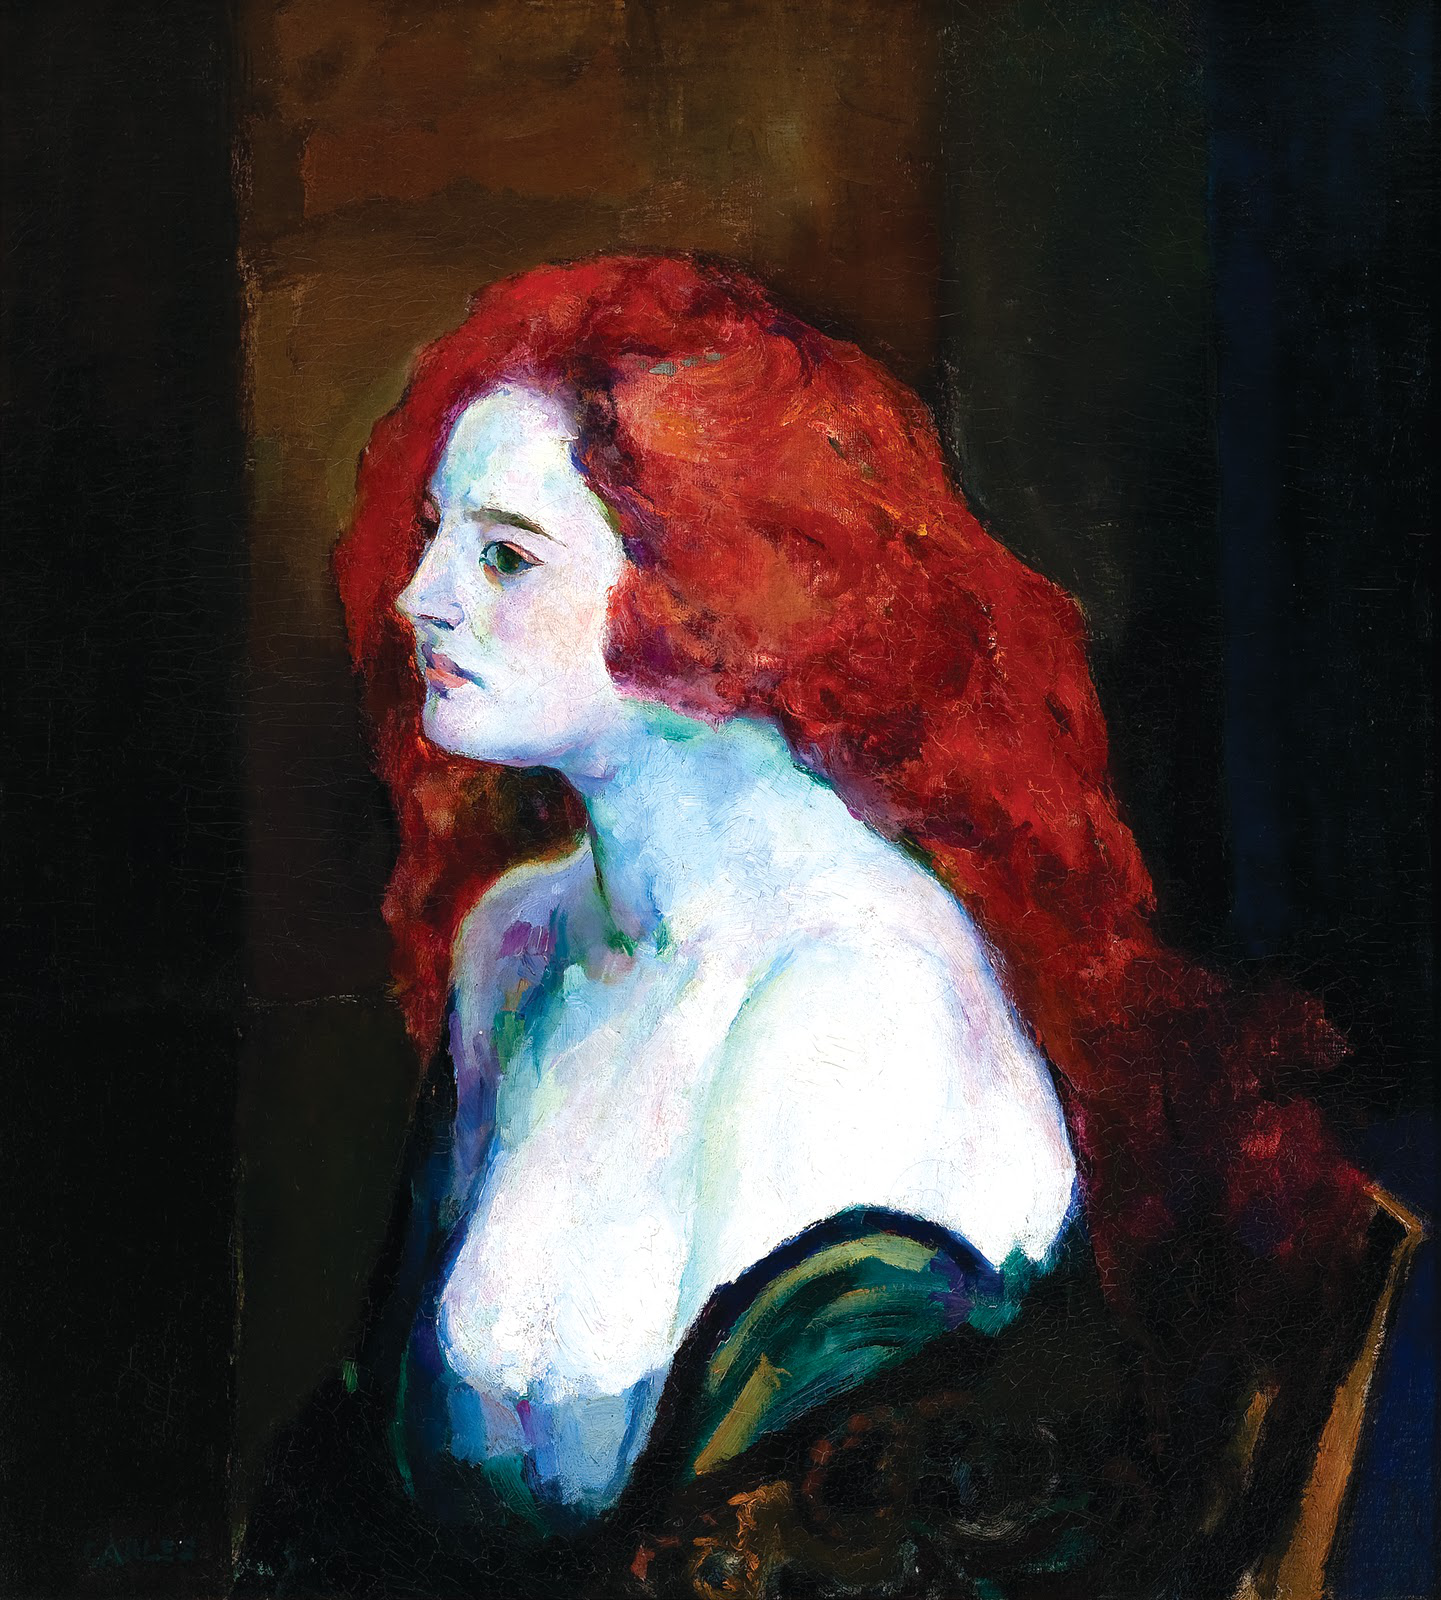

In [42]:
display(transforms.ToPILImage()(styles))

In [ ]:
t = torch.Tensor([[1, 2], [3, 4]])
print(torch.mean(t, (1), keepdims=True))